In [ ]:
# importing packages
%matplotlib inline
import numpy as np
import pandas as pd
import nltk

!pip install scikit-plot
!pip install distance
!pip install fuzzywuzzy

import re
import string
import distance

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from fuzzywuzzy import fuzz


import gensim
from gensim.models.doc2vec import Doc2Vec,TaggedDocument

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import nltk
#Nltk resource downloading
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
#Mounting a Google Drive
!pip install kora -q
from kora import drive
drive.mount("/content/drive/")
drive.link_nbs()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Data Loading**

In [ ]:
import os
base_file_path = "drive/MyDrive/Colab Notebooks/NLP/Project/data/"
train_data = base_file_path + "train.csv"
if os.path.isfile(train_data):
  df = pd.read_csv(train_data)
  print('----------Data Loaded---------------------')
else:
    print('------------Data Not Loaded---------------------')

----------Data Loaded---------------------


In [ ]:
print(f'Training Data Size: {df.shape}')

Training Data Size: (404290, 6)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Data Analysis

In [ ]:
#Data Checking
#1.Checking Null Values in whole file
print(f"Column Null Values Count\n{df.isna().sum()}")
print("-------------------------------")
#2.Checking Polarity Values
print(f"Unique Polarity Values\n{df['is_duplicate'].unique()}")


# Polarity column contain only two values - [0,1] which correspond to our data definition.

Column Null Values Count
id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64
-------------------------------
Unique Polarity Values
[0 1]


In [ ]:
# Dropping null entries
df = df.dropna()

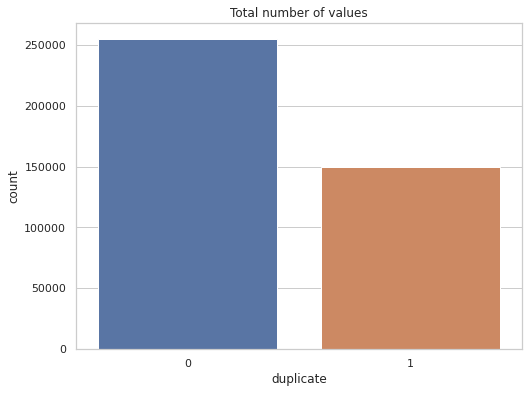

Total number of question pairs is 404287
Question pairs that are similar is 149263 which is 37 % of total
Question pairs that are not similar is 255024 which is 63 % of total


In [ ]:
# Analysis of distribution of target variables
plt.figure(figsize=(8,6))
sns.countplot(data=df,x='is_duplicate')
plt.title('Total number of values')
plt.xlabel('duplicate')
plt.ylabel('count')
plt.show()

# numerical analysis
target_value_counts = df['is_duplicate'].value_counts()
total_target_value_counts = target_value_counts[0] + target_value_counts[1]
print('Total number of question pairs is {}'.format(len(df.id.values)))
print('Question pairs that are similar is {} which is {} % of total'.format(target_value_counts[1],round((target_value_counts[1]/total_target_value_counts*100)),2))
print('Question pairs that are not similar is {} which is {} % of total'.format(target_value_counts[0],round((target_value_counts[0]/(total_target_value_counts)*100)),2))

**Data Pre-Processing**

In [ ]:
 # Declaring Regular Expression
url_reg_expr = re.compile(r'https?://\S+|www\.\S+')
html_reg_expr = re.compile(r'<.*?>')
emoji_reg_expr = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)

def remove_noise(sentence):
    #Remove White-Space characters
    sentence = sentence.strip()
    #Remove Urls
    sentence = url_reg_expr.sub(r'', sentence)
    #Remove HTML
    sentence = html_reg_expr.sub(r'',sentence)
    #Removeing Emojis
    sentence = emoji_reg_expr.sub(r'', sentence)
    # Converting to Lower case
    sentence = sentence.lower()
    # Replacing common short form
    sentence = sentence.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    # Replacing multiple digits representation to  miilion,thoudsands etc.. eg:1000 -> 1k
    sentence = re.sub(r"([0-9]+)000", r"\1k",  sentence)
    sentence = re.sub(r"([0-9]+)000000", r"\1m",  sentence) 
            
    return sentence

#Reasoning
#Punctuations,Urls,Html,Emoji creates noise in the data and, should be cleared. 
#For now, we don't have meaningful way to analyze punctuations

In [ ]:
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    #replacing multiple digits representation to  miilion,thoudsands etc.. eg:1000 -> 1k
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)  
    
    
    porter = PorterStemmer()    #apply stemming  eg: growing,growth --> grow
    pattern = re.compile('\W')  #matching word charecter
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [ ]:
#Applying Lemmatization
wnl = WordNetLemmatizer()
def apply_lemma(sentence):
  return " ".join(wnl.lemmatize(x) for x in word_tokenize(sentence) if x.isalnum())

In [ ]:
# Applying Porter Stemming
def apply_stemming(sentence):
    stemmer = PorterStemmer()
    return " ".join(stemmer.stem(x) for x in word_tokenize(sentence) if x.isalnum())


In [ ]:
# Transforming Training Data 
# df['question1'] = df['question1'].fillna("").apply(remove_noise)
# df['question2'] = df['question2'].fillna("").apply(remove_noise)
# print('------Noise Removal Pre Processing Step done.----------')
# df['question1'] = df['question2'].apply(apply_stemming)
# df['question2'] = df['question2'].apply(apply_stemming)
# print('------Stop Words Removal and Applying Stemming Pre Processing Step done.----------')
# df = df.fillna(' ')
# print('------------Pre-Processing Finished-----------------------')

------Noise Removal Pre Processing Step done.----------
------Stop Words Removal and Applying Stemming Pre Processing Step done.----------
------------Pre-Processing Finished-----------------------


In [ ]:
#Checking Null Values in whole file
print(f"Column Null Values Count\n{df.isna().sum()}")

Column Null Values Count
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


**Feature Extraction**

In [ ]:
STOP_WORDS = nltk.corpus.stopwords.words("english")

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    SAFE_DIV = 0.0001 
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))      # will return longest common substring 
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):

    print("token features...")

    df['question1'] = df['question1'].fillna("").apply(preprocess)
    df['question2'] = df['question2'].fillna("").apply(preprocess)
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
df = extract_features(df)
#Shuffling
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv(base_file_path + "/preprocessed_data.csv", index=False)

token features...
fuzzy features..


In [ ]:
df = pd.read_csv(base_file_path + "/preprocessed_data.csv")
print(f'Shape -- {df.shape}')
df.head(5)

Shape -- (404287, 21)


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,24826,46331,46332,why does the u s military use single use rocke...,why does the u s military use the at 4 if it ...,1,0.666656,0.666656,0.999975,0.444440,...,0.470585,0.0,1.0,6.0,14.0,81,68,69,64,0.288136
1,229511,103124,313667,why are condoms so baggy,why do we have flavored condoms,0,0.499975,0.499975,0.333322,0.249994,...,0.333328,0.0,1.0,1.0,5.5,65,47,55,60,0.346154
2,78247,25923,126004,how do i get a book published,how can i get my first book published,1,0.999967,0.749981,0.499988,0.499988,...,0.624992,1.0,1.0,1.0,7.5,91,76,79,73,0.516129
3,356905,486280,486281,can response surface methodology be used on ex...,how can i select a property of an object using...,0,0.166664,0.111110,0.499988,0.285710,...,0.199999,1.0,0.0,2.0,14.0,42,36,40,43,0.100000
4,112560,184144,184145,if i type a single letter into instagram searc...,why do people i do not follow on instagram sho...,0,0.714276,0.555549,0.428565,0.333330,...,0.399998,0.0,0.0,6.0,17.0,74,66,36,37,0.166667


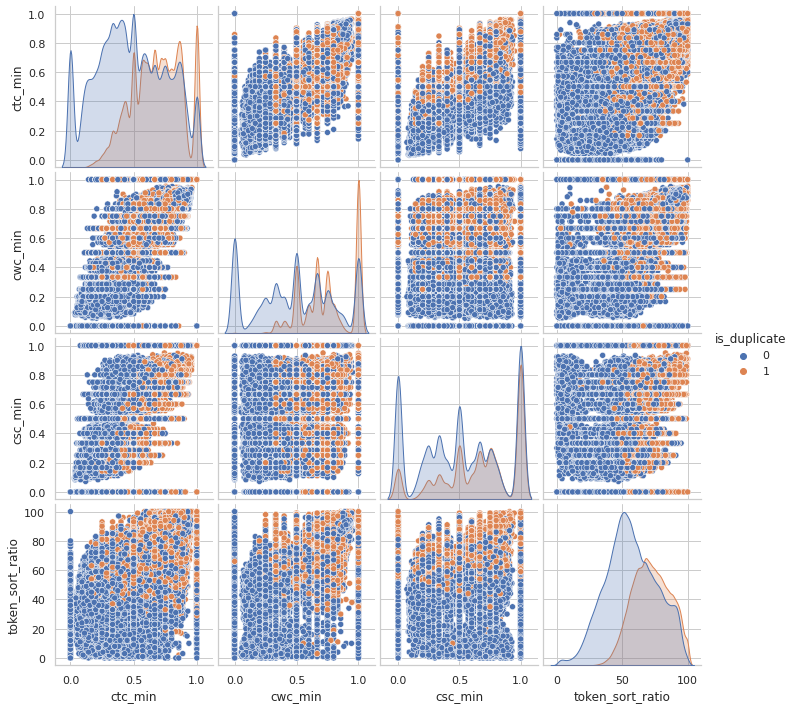

<Figure size 1152x576 with 0 Axes>

In [ ]:
# Pairwise Visualization
sns.pairplot(df, hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.figure(figsize=(16,8))
plt.show()

**Train,Test And Validation Split**

In [ ]:
X = df[['cwc_min','csc_min','token_sort_ratio','ctc_min']]
y = df.loc[:, ['is_duplicate']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)

In [ ]:
X.head(10)

,cwc_min,csc_min,token_sort_ratio,ctc_min
0,0.666656,0.999975,68,0.727266
1,0.499975,0.333322,47,0.399992
2,0.999967,0.499988,76,0.714276
3,0.166664,0.499988,36,0.230767
4,0.714276,0.428565,66,0.571424
5,0.999967,0.000000,66,0.499992
6,0.999975,0.666644,85,0.749991
7,0.999900,0.499975,64,0.666644
8,0.666644,0.333322,49,0.499992
9,0.399992,0.666644,60,0.444440


In [ ]:
#Data Analysis post splitting

#Training Data
print(f'Length:{len(y_train)}')
print(y_train['is_duplicate'].value_counts(normalize=True))
#Test Data
print(f'Length:{len(y_test)}')
print(y_test['is_duplicate'].value_counts(normalize=True))
# Shape
print(f'Dataframe shape - {X_train.shape}')

Length:270872
0    0.63012
1    0.36988
Name: is_duplicate, dtype: float64
Length:133415
0    0.632178
1    0.367822
Name: is_duplicate, dtype: float64
Dataframe shape - (270872, 4)


In [ ]:
#Normalization
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train = norm.transform(X_train)

# transform testing dataabs
X_test = norm.transform(X_test)

In [ ]:
#Splitting Training Data into Validation and Training data for model selection
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train,y_train,test_size=0.33,random_state=0)

In [ ]:
#Training Data After Splitting
print(f'Length:{len(y_train_val)}')
print(y_train_val['is_duplicate'].value_counts(normalize=True))
#Validation Data
print(f'Length:{len(y_val)}')
print(y_val['is_duplicate'].value_counts(normalize=True))

Length:181484
0    0.629725
1    0.370275
Name: is_duplicate, dtype: float64
Length:89388
0    0.630924
1    0.369076
Name: is_duplicate, dtype: float64


**Utility Function**

In [ ]:
import joblib
#Saving Model
def save_model(model,filename):
  # save the model to disk
  joblib.dump(model, filename)
  print('Model Saved')

def get_model(filename):
  if os.path.isfile(filename):
    # load the model from disk
    print('Model Exist')
    loaded_model = joblib.load(filename)
    print('Model Loaded')
    return loaded_model
  print('Model does not exist')
  return None

**Model Training**

In [ ]:
#MultinomialNB
base_file_path = 'drive/MyDrive/Colab Notebooks/NLP/Project/Model/'
# Checking If Model Exist then load it.
multinomial_nb_model_file_path = base_file_path + 'multi_nb_model.sav'
multinomial_nb_model =  get_model(multinomial_nb_model_file_path)
if multinomial_nb_model is None: 
  # Build the classifier
  multinomial_nb_model = MultinomialNB()
  #  Train the classifier
  multinomial_nb_model.fit(X_train_val, y_train_val['is_duplicate'].values)
  save_model(multinomial_nb_model,multinomial_nb_model_file_path)

Model does not exist
Model Saved


In [ ]:
#BernoulliNB
# Checking If Model Exist then load it.
bernoulli_nb_model_file_path = base_file_path + 'bernoulli_nb_model.sav'
bernoulli_nb_model =  get_model(bernoulli_nb_model_file_path)
if bernoulli_nb_model is None:
  # Build the classifier
  bernoulli_nb_model = BernoulliNB()
  #  Train the classifier
  bernoulli_nb_model.fit(X_train_val, y_train_val['is_duplicate'].values)
  save_model(bernoulli_nb_model,bernoulli_nb_model_file_path)

Model does not exist
Model Saved


In [ ]:
#Logistic Regression
from sklearn.model_selection import GridSearchCV

log_reg_model_file_path = base_file_path + 'log_reg_model.sav'
log_reg_model =  get_model(log_reg_model_file_path)
if log_reg_model is None:
    params = {
              'C': np.logspace(-2, 7, 5),
              'tol': np.logspace(-5, -1, 5)
              }
    log_reg_model = LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000)
    log_reg_model_cv = GridSearchCV(log_reg_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
    log_reg_model_cv.fit(X_train_val, y_train_val)
    # train the tuned model
    log__reg_model = LogisticRegression(random_state=42, 
                                C=log_reg_model_cv.best_params_['C'], 
                                tol=log_reg_model_cv.best_params_['tol'], 
                                n_jobs=-1)
    log_reg_model.fit(X_train_val, y_train_val['is_duplicate'].values)
    save_model(log_reg_model,log_reg_model_file_path)

Model does not exist
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Saved


In [ ]:
# Decision Tree
decision_tree_model_file_path = base_file_path + 'decision_tree_model.sav'
decision_tree_model =  get_model(decision_tree_model_file_path)
if decision_tree_model is None:
    params = {
    'max_depth': [10,15,20],
    'min_samples_split': [2,4,6], 
    'min_samples_leaf':[100,200,300]
    }
    # Checking If Model Exist then load it.
    decision_tree_model = DecisionTreeClassifier()
    decision_tree_model_cv = GridSearchCV(decision_tree_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
    decision_tree_model_cv.fit(X_train_val, y_train_val)
    # train the tuned model
    decision_tree_model = DecisionTreeClassifier( 
                                max_depth = decision_tree_model_cv.best_params_['max_depth'], 
                                min_samples_split = decision_tree_model_cv.best_params_['min_samples_split'],
                                min_samples_leaf = decision_tree_model_cv.best_params_['min_samples_leaf'])
    decision_tree_model.fit(X_train_val, y_train_val['is_duplicate'].values)
    save_model(decision_tree_model,decision_tree_model_file_path)

Model does not exist
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Model Saved


In [ ]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

random_forest_model_file_path = base_file_path + 'random_forest_model.sav'
random_forest_model =  get_model(random_forest_model_file_path)
if random_forest_model is None:
    #Finding Best Hyperparameter For Random Forest
    params = {
    'max_depth': [10,15,20],
    'min_samples_split': [2,4,6], 
    'min_samples_leaf':[100,200,300]
    }
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model_cv = GridSearchCV(rf_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
    rf_model_cv.fit(X_train_val, y_train_val['is_duplicate'].values)
    # train the tuned model
    rf_model = RandomForestClassifier(n_estimators=100,
                                    max_depth = rf_model_cv.best_params_['max_depth'], 
                                    min_samples_split = rf_model_cv.best_params_['min_samples_split'],
                                    min_samples_leaf = rf_model_cv.best_params_['min_samples_leaf'])
    rf_model.fit(X_train_val, y_train_val['is_duplicate'].values)
    save_model(rf_model,random_forest_model_file_path)

Model does not exist
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Model Saved


**Performance Evaluation**

In [ ]:
#Utility Function for measuring Performance
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
            TP += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==1:
            TN += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FN += 1
    FPR = (FP)/(FP+TN)
    TPR = (TP)/(TP+FN)
    total_predictions = TP + TN + FP + FN
    return {'True Negative %':(TN/total_predictions)*100,'True Positive %':(TP/total_predictions)*100,
            'Misclassification %':((FP + FN)/total_predictions)*100}

def report(model,X,Y,modelName,report_type,accuracy_scores):
    YPred = model.predict(X)
    if report_type == 0:
        print(f"{modelName} Training Data Result:\n================================================")
    elif report_type == 1:
        print(f"{modelName}  Validation Data Result:\n================================================")
    else:
        print(f"{modelName}  Test Data Result:\n================================================")
    model_accuracy_score = accuracy_score(Y, YPred) * 100
    print(f"Accuracy Score: {model_accuracy_score:.2f}%")
    print("_______________________________________________")
    clf_report = pd.DataFrame(classification_report(Y, YPred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    skplt.metrics.plot_confusion_matrix(Y, YPred)
    metrics_dict = perf_measure(Y.is_duplicate.values,YPred)
    print('-'*50)
    for key,value in metrics_dict.items():
        print(f'{key}  {value}')
    print('-'*50)
    accuracy_scores.append(model_accuracy_score)


**Training Data Performance**

Multinomial NB Model Training Data Result:
Accuracy Score: 62.97%
_______________________________________________


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLASSIFICATION REPORT:
                       0        1  accuracy      macro avg   weighted avg
precision       0.629725      0.0  0.629725       0.314862       0.396553
recall          1.000000      0.0  0.629725       0.500000       0.629725
f1-score        0.772799      0.0  0.629725       0.386400       0.486651
support    114285.000000  67199.0  0.629725  181484.000000  181484.000000
--------------------------------------------------
True Negative %  0.0
True Positive %  62.97249344294814
Misclassification %  37.02750655705186
--------------------------------------------------


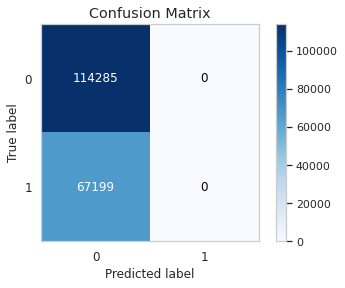

In [ ]:
training_accuracy_scores = []
report(multinomial_nb_model,X_train_val, y_train_val,'Multinomial NB Model',0,training_accuracy_scores)

Bernoulli NB Model Training Data Result:
Accuracy Score: 62.97%
_______________________________________________


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLASSIFICATION REPORT:
                       0        1  accuracy      macro avg   weighted avg
precision       0.629725      0.0  0.629725       0.314862       0.396553
recall          1.000000      0.0  0.629725       0.500000       0.629725
f1-score        0.772799      0.0  0.629725       0.386400       0.486651
support    114285.000000  67199.0  0.629725  181484.000000  181484.000000
--------------------------------------------------
True Negative %  0.0
True Positive %  62.97249344294814
Misclassification %  37.02750655705186
--------------------------------------------------


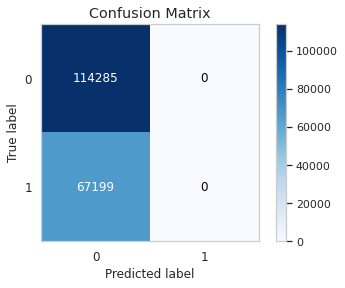

In [ ]:
report(bernoulli_nb_model,X_train_val, y_train_val,'Bernoulli NB Model',0,training_accuracy_scores)

Logistic NB Model Training Data Result:
Accuracy Score: 66.29%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.710848      0.554152  0.662879       0.632500       0.652827
recall          0.783261      0.458147  0.662879       0.620704       0.662879
f1-score        0.745300      0.501597  0.662879       0.623448       0.655063
support    114285.000000  67199.000000  0.662879  181484.000000  181484.000000
--------------------------------------------------
True Negative %  16.96402988693218
True Positive %  49.32390734169403
Misclassification %  33.71206277137379
--------------------------------------------------


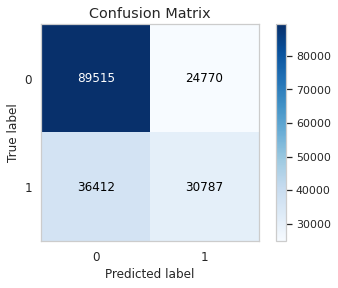

In [ ]:
report(log_reg_model,X_train_val, y_train_val,'Logistic NB Model',0,training_accuracy_scores)

Decision Tree Model Training Data Result:
Accuracy Score: 72.10%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.778758      0.622987  0.720973       0.700873       0.721080
recall          0.777906      0.624146  0.720973       0.701026       0.720973
f1-score        0.778332      0.623566  0.720973       0.700949       0.721026
support    114285.000000  67199.000000  0.720973  181484.000000  181484.000000
--------------------------------------------------
True Negative %  23.1105772409689
True Positive %  48.98668753168323
Misclassification %  27.902735227347865
--------------------------------------------------


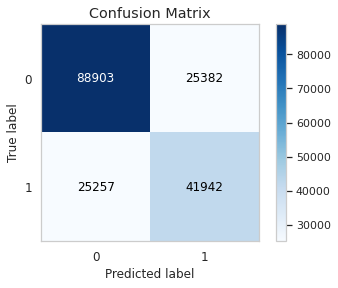

In [ ]:
report(decision_tree_model,X_train_val, y_train_val,'Decision Tree Model',0,training_accuracy_scores)

In [ ]:
report(rf_model,X_train_val, y_train_val,'Random Forest Model',0,training_accuracy_scores)

**Validation Data Performance**

Multinomial NB Model  Validation Data Result:
Accuracy Score: 63.09%
_______________________________________________


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLASSIFICATION REPORT:
                      0        1  accuracy     macro avg  weighted avg
precision      0.630924      0.0  0.630924      0.315462      0.398065
recall         1.000000      0.0  0.630924      0.500000      0.630924
f1-score       0.773701      0.0  0.630924      0.386850      0.488146
support    56397.000000  32991.0  0.630924  89388.000000  89388.000000
--------------------------------------------------
True Negative %  0.0
True Positive %  63.09236139079071
Misclassification %  36.90763860920929
--------------------------------------------------


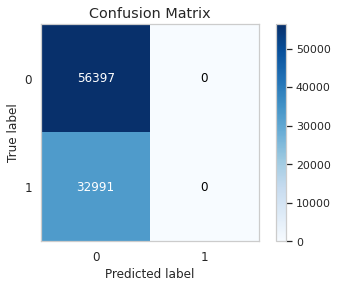

In [ ]:
validation_accuracy_scores = []
report(multinomial_nb_model,X_val,y_val,'Multinomial NB Model',1,validation_accuracy_scores)

Bernoulli NB Model  Validation Data Result:
Accuracy Score: 63.09%
_______________________________________________


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLASSIFICATION REPORT:
                      0        1  accuracy     macro avg  weighted avg
precision      0.630924      0.0  0.630924      0.315462      0.398065
recall         1.000000      0.0  0.630924      0.500000      0.630924
f1-score       0.773701      0.0  0.630924      0.386850      0.488146
support    56397.000000  32991.0  0.630924  89388.000000  89388.000000
--------------------------------------------------
True Negative %  0.0
True Positive %  63.09236139079071
Misclassification %  36.90763860920929
--------------------------------------------------


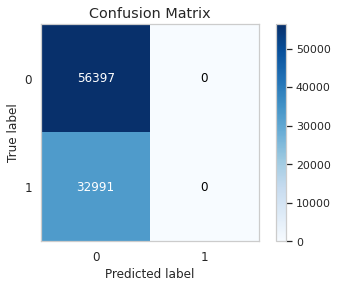

In [ ]:
report(bernoulli_nb_model,X_val,y_val,'Bernoulli NB Model',1,validation_accuracy_scores)

Logistic NB Model  Validation Data Result:
Accuracy Score: 66.64%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.713814      0.558162  0.666376      0.635988      0.656367
recall         0.786567      0.460914  0.666376      0.623740      0.666376
f1-score       0.748427      0.504898  0.666376      0.626662      0.658546
support    56397.000000  32991.000000  0.666376  89388.000000  89388.000000
--------------------------------------------------
True Negative %  17.0112319326979
True Positive %  49.62634805566743
Misclassification %  33.36242001163467
--------------------------------------------------


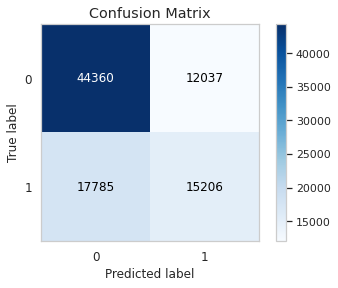

In [ ]:
report(log_reg_model,X_val,y_val,'Logistic NB Model',1,validation_accuracy_scores)

Decision Tree Model  Validation Data Result:
Accuracy Score: 71.62%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.774297      0.616109  0.716204      0.695203      0.715913
recall         0.776548      0.613046  0.716204      0.694797      0.716204
f1-score       0.775421      0.614574  0.716204      0.694997      0.716056
support    56397.000000  32991.000000  0.716204  89388.000000  89388.000000
--------------------------------------------------
True Negative %  22.62607956325234
True Positive %  48.99427216181143
Misclassification %  28.37964827493623
--------------------------------------------------


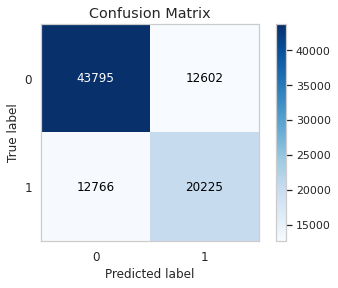

In [ ]:
report(decision_tree_model,X_val,y_val,'Decision Tree Model',1,validation_accuracy_scores)

In [ ]:
report(rf_model,X_val,y_val,'Random Forest Model',1,validation_accuracy_scores)

In [ ]:
def create_barplot(df,x_label,y_label,x_col,y_col,filename):
    plt.figure(figsize=(12,6),dpi=100)
    plt.style.use('ggplot')
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=x_col,y=y_col,data=df,palette="Set2")
    
    for bar in ax.patches:
      ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

    ax.set(xlabel=x_label, ylabel=y_label)
    ax.tick_params(axis='x', rotation=30)
    plt.setp(ax.patches, linewidth=0)
    # plt.legend(title = 'Team Name', bbox_to_anchor=(1, 1))
    file_path = f'drive/MyDrive/Colab Notebooks/NLP/Project/Results/{filename}.png'
    plt.savefig(file_path,bbox_inches = 'tight')
    plt.show()



In [ ]:
print(f'Training Accuracy Score -- {training_accuracy_scores}')
print(f'Validation Accuracy Score -- {validation_accuracy_scores}')

Training Accuracy Score -- [62.97249344294814, 62.97249344294814, 66.28793722862622, 72.09726477265214]
Validation Accuracy Score -- [63.09236139079071, 63.09236139079071, 66.63757998836533, 71.62035172506377]


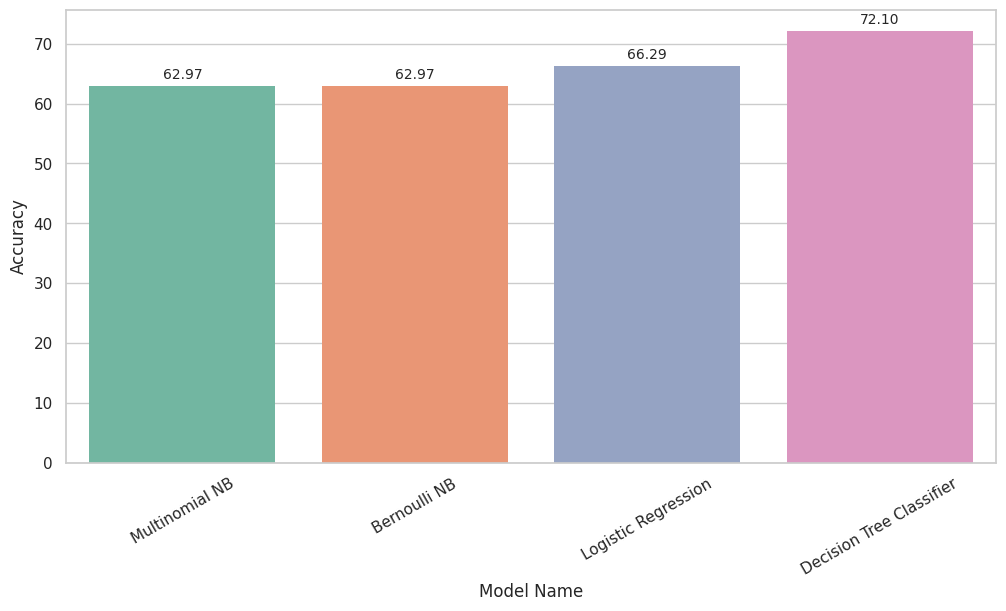

In [ ]:
model_name_list = ['Multinomial NB','Bernoulli NB','Logistic Regression','Decision Tree Classifier']
df_train = pd.DataFrame(model_name_list,columns=['model_name'])
df_train['accuracy_score'] = training_accuracy_scores
df_val = pd.DataFrame(model_name_list,columns=['model_name'])
df_val['accuracy_score'] = validation_accuracy_scores
create_barplot(df_train,'Model Name','Accuracy','model_name','accuracy_score','train_accuracy')

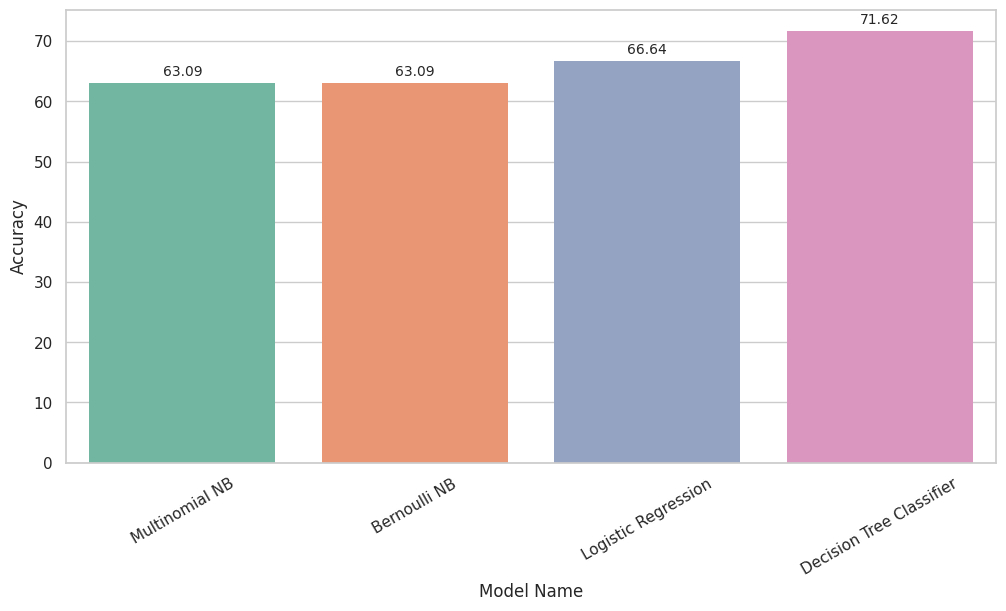

In [ ]:
create_barplot(df_val,'Model Name','Accuracy','model_name','accuracy_score','val_accuracy')

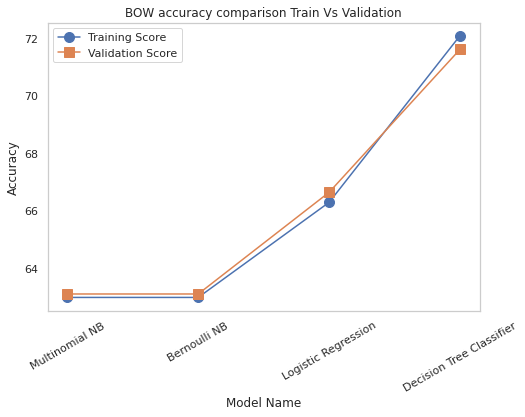

In [ ]:
#Creating Canvas
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_ylabel('Accuracy')
ax.set_xlabel('Model Name')
ax.set_title('BOW accuracy comparison Train Vs Validation')

#Creating Multiline Plot
ax.plot(model_name_list,training_accuracy_scores, label="Training Score",marker='o',ms=10)
ax.plot(model_name_list,validation_accuracy_scores, label="Validation Score",marker='s',ms=10)

ax.grid(False)
ax.set_facecolor('white')
ax.legend()
ax.tick_params(axis='x', rotation=30)
file_path = f'drive/MyDrive/Colab Notebooks/NLP/Project/Results/accuracy_comp.png'
plt.savefig(file_path,bbox_inches = 'tight')
plt.show()
plt.close()

Test Data Evaluation

Decision Tree Model  Test Data Result:
Accuracy Score: 71.57%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.775246      0.613389  0.715662       0.694318       0.715711
recall         0.774869      0.613902  0.715662       0.694385       0.715662
f1-score       0.775057      0.613645  0.715662       0.694351       0.715686
support    84342.000000  49073.000000  0.715662  133415.000000  133415.000000
--------------------------------------------------
True Negative %  22.58066934002923
True Positive %  48.985496383465126
Misclassification %  28.433834276505642
--------------------------------------------------


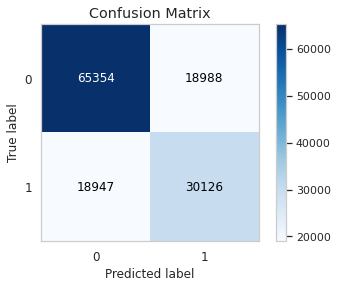

In [ ]:
report(decision_tree_model,X_test,y_test,'Decision Tree Model',2,[])

Work Left---
1. Feature Selection
2. Trying other  ML and DL Models
3. Utilising Unsupervised Test Data